# Mean field theory solution

In [16]:
const N_DIMS = 2
include("MFT_soln.jl")

pressures = collect(linspace(0.001, 2.0, 30)) # bar
temperature = 273.0 # K
RT = 8.314 * temperature / 1000.0 # kJ/mol for Qst
n_sites = 100

# For Kr in MIL-91(Al)
site_volume = 12.32 # A^3, motivated by MIL-93(Al)
energy_params = construct_energy_param(ϵ_0=13.0, ϵ=5.5, ϵ_l=3.0)

EnergyParams(3.0,5.5,13.0)

## Solve MFT eqns

Isotherm and concomitant linker configurations. This uses different starting guesses to get the adsorption and desorption branch.

`df_mft["adsorption"]` and `df_mft["adsorption"]` then give two branches.

In [2]:
pressures_mft = collect(linspace(0, 0.1, 350))

df_mft = mft_isotherm(pressures_mft, energy_params, n_sites, site_volume, temperature)

Dict{AbstractString,DataFrames.DataFrame} with 2 entries:
  "desorption" => 335×3 DataFrames.DataFrame…
  "adsorption" => 208×3 DataFrames.DataFrame…

Find two jumps in MFT solution. Do this by enforcing self-consistency equations and also that the self-consistency equations are tangent to constrain the pressure.

In [3]:
nlp_jump1 = find_mft_jump(energy_params, n_sites, site_volume, temperature, [.01, .01, .01])
nlp_jump2 = find_mft_jump(energy_params, n_sites, site_volume, temperature, [.8, .8, .1])
@printf("First jump at n = %.3f l = %.3f p = %.3f\n", nlp_jump1[1], nlp_jump1[2], nlp_jump1[3])
@printf("Second jump at n = %.3f l = %.3f p = %.3f\n", nlp_jump2[1], nlp_jump2[2], nlp_jump2[3])

# ADsorption at end of DEsorption branch
ads_at_end_of_des = mft_soln(minimum([nlp_jump1[3], nlp_jump2[3]]), energy_params, 
                        n_sites, site_volume, temperature, nl_guess=[.01, .2])
des_at_end_of_ads = mft_soln(maximum([nlp_jump1[3], nlp_jump2[3]]), energy_params, 
                        n_sites, site_volume, temperature, nl_guess=[.7, .9])
[maximum(df_mft["adsorption"][:l]), des_at_end_of_ads[2]]

First jump at n = 0.111 l = 0.314 p = 0.060
Second jump at n = 0.703 l = 0.904 p = 0.004


2-element Array{Float64,1}:
 0.304558
 0.969478

In [4]:
nlp_jump1

3-element Array{Float64,1}:
 0.11123  
 0.313762 
 0.0595352

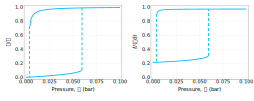

In [5]:
myplot_n = plot(
#     # Exact solution
#     layer(x=df_exact[:P], y=df_exact[:n], Geom.line, Theme(default_color=colorant"green", line_width=.9mm)),
#     layer(x=df_high[:P], y=df_high[:n], Geom.line, Theme(default_color=colorant"red", line_width=.9mm)),
#     layer(x=df_low[:P], y=df_low[:n], Geom.line, Theme(default_color=colorant"blue", line_width=.9mm)),

    # Mean field model
    layer(x=df_mft["adsorption"][:P], y=df_mft["adsorption"][:n], Geom.line, 
        Theme(line_width=0.9mm)),
    layer(x=df_mft["desorption"][:P], y=df_mft["desorption"][:n], Geom.line, 
        Theme(line_width=0.9mm)),
    
    # Draw pressure of jump
#     Geom.vline(),
#     xintercept=[nlp_jump1[3], nlp_jump2[3]],
    layer(x=[nlp_jump1[3], nlp_jump1[3]], y=[maximum(df_mft["adsorption"][:n]), des_at_end_of_ads[1]], Geom.line, 
            Theme(line_width=0.9mm,
                line_style=Gadfly.get_stroke_vector(:dot))),
    layer(x=[nlp_jump2[3], nlp_jump2[3]], y=[minimum(df_mft["desorption"][:n]), ads_at_end_of_des[1]], Geom.line, 
                Theme(line_width=0.9mm, 
                    line_style=Gadfly.get_stroke_vector(:dot))),

#     Coord.Cartesian(xmax=1.0),

    Guide.xlabel("Pressure, 𝑃 (bar)"),
    Guide.ylabel("𝑛/𝑀"),
   # Guide.title("Adsorption isotherm"),
#     Geom.vline(),
#     xintercept=p_jump,
#     Coord.Cartesian(xmax=0.15),
 #   Guide.xticks(ticks=collect(0.0:0.2:1.0)),
    Guide.yticks(ticks=collect(0.0:0.2:1.0)),
    Guide.xticks(ticks=collect(0.0:0.025:0.1)),
#     Guide.xticks(ticks=collect(0.0:0.2:1.0)),
    #Geom.hline,
    #yintercept=[N_SITES * 1.0],
    Theme(background_color=colorant"white", panel_stroke=colorant"black",
            line_width=.9mm, major_label_font_size=15pt, minor_label_font_size=14pt,
            key_label_font_size=13pt, key_title_font_size=16pt,
            minor_label_color=colorant"black", major_label_color=colorant"black", 
            key_title_color=colorant"black", key_label_color=colorant"black"
    ),
#     Guide.manual_color_key("", 
#         ["MFT", "Exact", "ϵ<sub>ℓ</sub>→-∞ ", "ϵ<sub>ℓ</sub>→+∞"], 
#         [colorant"orange", colorant"green", colorant"red", colorant"blue"]
#     )
)

myplot_l = plot(
#     # Exact solution
#     layer(x=df_exact[:P], y=df_exact[:l], Geom.line, Theme(default_color=colorant"green", line_width=.9mm)),
#     layer(x=df_high[:P], y=df_high[:l], Geom.line, Theme(default_color=colorant"red", line_width=.9mm)),
#     layer(x=df_low[:P], y=df_low[:l], Geom.line, Theme(default_color=colorant"blue", line_width=.9mm)),

    # Mean field model
    layer(x=df_mft["adsorption"][:P], y=df_mft["adsorption"][:l], Geom.line, 
        Theme(line_width=0.9mm)),
    layer(x=df_mft["desorption"][:P], y=df_mft["desorption"][:l], Geom.line, 
        Theme(line_width=0.9mm)),

    # Draw pressure of jump
#     Geom.vline(),
#     xintercept=[nlp_jump1[3], nlp_jump2[3]],
    layer(x=[nlp_jump1[3], nlp_jump1[3]], y=[maximum(df_mft["adsorption"][:l]), des_at_end_of_ads[2]], Geom.line, 
            Theme(line_width=0.9mm,
                line_style=Gadfly.get_stroke_vector(:dot))),
    layer(x=[nlp_jump2[3], nlp_jump2[3]], y=[minimum(df_mft["desorption"][:l]), ads_at_end_of_des[2]], Geom.line, 
                Theme(line_width=0.9mm, 
                    line_style=Gadfly.get_stroke_vector(:dot))),

#     Coord.Cartesian(xmax=1.0),

    Guide.xlabel("Pressure, 𝑃 (bar)"),
    Guide.ylabel("ℓ/(𝑀d)"),
#    Guide.title("Ligand configurations"),
#    Coord.Cartesian(xmax=0.15),
    Guide.yticks(ticks=collect(0.0:0.2:1.0)),
    Guide.xticks(ticks=collect(0.0:0.025:0.1)),
    #Geom.hline,
    #yintercept=[N_SITES * 1.0],
    Theme(background_color=colorant"white", panel_stroke=colorant"black",
            line_width=.9mm, major_label_font_size=15pt, minor_label_font_size=14pt,
            key_label_font_size=13pt, key_title_font_size=16pt,
            minor_label_color=colorant"black", major_label_color=colorant"black", 
            key_title_color=colorant"black", key_label_color=colorant"black"),
#     Guide.manual_color_key("", 
#         ["MFT", "Exact", "ϵ<sub>ℓ</sub>→-∞ ", "ϵ<sub>ℓ</sub>→+∞"], 
#         [colorant"orange", colorant"green", colorant"red", colorant"blue"]
#     )
)

draw(PDF("MFT_soln.pdf", 10inch, 4inch), hstack(myplot_n, myplot_l))
draw(SVG(10inch, 4inch), hstack(myplot_n, myplot_l))#

In [6]:
df_mft["desorption"][:l]

335-element DataArrays.DataArray{Float64,1}:
 0.900328
 0.917969
 0.926325
 0.931928
 0.936097
 0.939374
 0.942041
 0.944267
 0.94616 
 0.947792
 0.949217
 0.950473
 0.95159 
 ⋮       
 0.970228
 0.970231
 0.970235
 0.970238
 0.970242
 0.970245
 0.970248
 0.970252
 0.970255
 0.970258
 0.970262
 0.970265

## Graphical Solution

Draw a self-consistency curve for $n$ for each pressure in this array.

In [7]:
nlp_jump2[3]

0.003688903968380262

In [8]:
pressures_mft = collect(logspace(-3, log10(0.1), 10))

10-element Array{Float64,1}:
 0.001     
 0.0016681 
 0.00278256
 0.00464159
 0.00774264
 0.0129155 
 0.0215443 
 0.0359381 
 0.0599484 
 0.1       

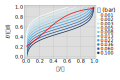

In [9]:
mft_graphical_soln_plot = plot_graphical_MFT_soln(pressures_mft, energy_params, site_volume, temperature)

draw(SVG(12cm, 8cm), mft_graphical_soln_plot)
draw(PDF("graphical_soln.pdf", 12cm, 8cm), mft_graphical_soln_plot)

### Visualize the grand potential $\Omega$

In [17]:
n = linspace(0, 1, 100) * n_sites
l = linspace(0, 1, 100) * n_sites * N_DIMS

function viz_Ω_MFT(pressure_in_bar::Float64, savename::String)
    # store value of grand potential at this n and l in a matrix.
    Ω = zeros(Float64, length(n), length(l))
    for i = 1:length(n)
        for j = 1:length(l)
            Ω[i, j] = Ω_mft(energy_params, n_sites, site_volume, temperature, pressure_in_bar, n[i], l[j])
        end
    end
  #  Ω = Ω - minimum(Ω)
    
    # find minimum value
    idx = n .< 0.5 * n_sites
    n_min_low, l_min_low = ind2sub(size(Ω[idx, idx]), indmin(Ω[idx, idx]))
    n_min_high, l_min_high = ind2sub(size(Ω[!idx, !idx]), indmin(Ω[!idx, !idx]))
    n_min_high += sum(idx)
    l_min_high += sum(idx)
    if (pressure_in_bar < .005) # only one minimum
        n_min_high=n_min_low
        l_min_high=l_min_low
    elseif (pressure_in_bar > maximum([nlp_jump1[3], nlp_jump2[3]]))
        n_min_low=n_min_high
        l_min_low=l_min_high
    end
    
    Ω_levels = collect(logspace(log10(minimum(Ω)+.5), log10(maximum(Ω))))
    
    grand_potential_plots = plot(
        # plot minima
        layer(x=[n[n_min_low] / n_sites], y=[l[l_min_low] / n_sites / N_DIMS], 
                Geom.point, Theme(default_color=colorant"red")),
        layer(x=[n[n_min_high] / n_sites], y=[l[l_min_high] / n_sites / N_DIMS], 
            Geom.point, Theme(default_color=colorant"red")),
        layer(x=n / n_sites, y=l / n_sites / N_DIMS, z=Ω, 
            #Geom.contour(levels=collect(logspace(-5, log(maximum(Ω)), 15))),
            Geom.contour(levels=Ω_levels)#collect(linspace(0.0, maximum(Ω), 25)))
        ),
        Guide.xlabel("𝑛/𝑀"),
        Guide.ylabel("ℓ/(𝑀d)"),
        Guide.colorkey("Ω (kJ/mol)"),
        Guide.yticks(ticks=collect(0.0:0.2:1.0)),
        Guide.xticks(ticks=collect(0.0:0.2:1.0)),
        Guide.title(@sprintf("P = %.3f bar", pressure_in_bar)),
        Theme(background_color=colorant"white", panel_stroke=colorant"black",
            line_width=.7mm, major_label_font_size=15pt, minor_label_font_size=14pt, 
            key_label_font_size=14pt, key_title_font_size=16pt,
            minor_label_color=colorant"black", major_label_color=colorant"black", 
            key_title_color=colorant"black", key_label_color=colorant"black"),
    )
    
    draw(PDF(savename, 12cm, 9cm), grand_potential_plots)
    draw(SVG(12cm, 9cm), grand_potential_plots)
end

viz_Ω_MFT (generic function with 1 method)

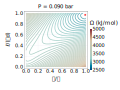

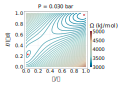

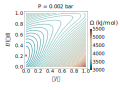

In [15]:
viz_Ω_MFT(.09, "Ω_high.pdf")
viz_Ω_MFT(0.03, "Ω_mid.pdf")
viz_Ω_MFT(0.002, "Ω_low.pdf")